# Tractable Gaussian Approximate Infernece

In [91]:
import numpy as np
import matplotlib.pyplot as plt

In [92]:
np.random.seed(0)

In [93]:
class TAGI:
    """
    Implementation of TAGI (Traceable Approximate Gaussian Inference) based on the paper:
    Tractable approximate Gaussian inference for Bayesian neural networks (James-A. Goulet, Luong-Ha Nguyen, and Said Amiri. JMLR, 2021)
    https://jmlr.csail.mit.edu/papers/volume22/20-1009/20-1009.pdf
    """

    def __init__(self, layers):
        """
        Initialize the TAGI model.

        Input:
        layers: list of integers, specifying the number of neurons in each layer.

        Output:
        Initializes the model parameters and hidden states.
        """
        self.layers = layers
        self.parameters = self.init_parameters(layers)
        self.hidden_states = self.init_hidden_states(layers)
        self.covariances = self.init_covariances(layers)
        self.mu = 0
        self.sigma = 1

    def standardize_data(self, X):
        """
        Standardize the input data by subtracting the mean and dividing by the standard deviation.

        Input:
        X: ndarray of shape (n_samples), the input data.

        Output:
        ndarray of shape (n_samples), the standardized data.
        """
        self.mu = np.mean(X)
        self.sigma = np.std(X)
        return (X - self.mu) / self.sigma

    def unstandardize_data(self, X):
        """
        Convert standardized data back to its original scale.

        Input:
        X: ndarray of shape (n_samples), the standardized data.

        Output:
        ndarray of shape (n_samples), the unstandardized data.
        """
        return X * self.sigma + self.mu

    def init_parameters(self, layers):
        """
        Initialize weights and biases for each layer.

        Input:
        layers: list of integers, specifying the number of neurons in each layer.

        Output:
        parameters: list of dictionaries, where each dictionary contains:
            - mw: ndarray of shape (n_inputs, n_outputs), the mean values of the weights.
            - Sw: ndarray of shape (n_inputs, n_outputs), the variances of the weights.
            - mb: ndarray of shape (n_outputs,), the mean values of the biases.
            - Sb: ndarray of shape (n_outputs,), the variances of the biases.
        """
        parameters = []
        for i in range(len(layers) - 1):
            input_size = layers[i]
            output_size = layers[i + 1]
            parameters.append(
                {
                    "mw": np.random.randn(output_size, input_size)
                    * (0.5 / input_size) ** 0.5,
                    "Sw": np.ones((output_size, input_size)) / input_size,
                    "mb": np.random.randn(output_size, 1) * 1 / input_size,
                    "Sb": np.ones((output_size, 1)) * 0.5,
                }
            )
        return parameters

    def init_hidden_states(self, layers):
        """
        Initialize the hidden states for each layer.

        Input:
        layers: list of integers, specifying the number of neurons in each layer.

        Output:
        hidden_states: list of dictionaries, where each dictionary contains:
            - 'ma': ndarray of shape (n_neurons,1), the mean values of the activation units.
            - 'Sa': ndarray of shape (n_neurons,n_neurons), the variances of the activation units.
            - 'J': ndarray of shape (n_neurons,1), the Jacobian of the activation function.
        """
        hidden_states = []
        for layer_size in layers:
            hidden_states.append(
                {
                    "ma": np.zeros((layer_size, 1)),
                    "Sa": np.ones((layer_size, 1)),
                    "J": np.ones((layer_size, 1)),
                }
            )
        return hidden_states

    def init_covariances(self, layers):
        """
        Initialize the covariances for each layer.

        Input:
        layers: list of integers, specifying the number of neurons in each layer.

        Output:
        covariances: list of dictionaries, where each dictionary contains:
            - 'covZw': ndarray of shape (n_inputs, n_outputs), the covariances of the hidden states and weights.
            - 'covZb': ndarray of shape (n_outputs,), the covariances of the hidden states and biases.
            - 'covZZ': ndarray of shape (n_neurons, n_neurons), the covariances of two consecutive hidden states.
        """
        covariances = []
        for i in range(len(layers) - 1):
            input_size = layers[i]
            output_size = layers[i + 1]
            covariances.append(
                {
                    "covZw": np.zeros((output_size, input_size)),
                    "covZb": np.zeros((output_size, 1)),
                    "covZZ": np.zeros((output_size, input_size)),
                }
            )

        return covariances

    def GMA(self, ma, Sa, mw, Sw):
        """
        Gaussian Multiplicative Approximation (GMA)

        Input:
        ma: ndarray of shape (n_inputs,), mean values of the activation units.
        Sa: ndarray of shape (n_inputs,), variances of the activation units.
        mw: ndarray of shape (n_inputs, n_outputs), mean values of the weights.
        Sw: ndarray of shape (n_inputs, n_outputs), variances of the weights.

        Output:
        mu: ndarray of shape (n_outputs,), the means of the next hidden layer.
        var: ndarray of shape (n_outputs,), the variances of the next hidden layer.

        Remember that in GMA, given X1 and X2 random gaussian variables,
        Expected value: E[X1 * X2] = μ1 * μ2 + cov(X1, X2)
        Variance: var[X1 * X2] = var(X1) * var(X2) + cov(X1, X2)^2 +
                  2cov(X1,X2)μ1μ2 + var(X1) * μ2^2 + var(X2) * μ1^2

        Also remebmer that the activation units and the weights are independent in a neural network.
        """
        # To-do: Implement GMA and compute mu and var.

        # Expected value E[X1 * X2] = μ1 * μ2
        mu = mw @ ma  # Matrix product of means

        # Variance calculation
        # var[X1 * X2] = Sa * Sw + (Sa * mw^2) + (Sw * ma^2)
        var = (Sw @ Sa) + (Sw @ ma**2) + (mw**2 @ Sa)

        mu = mu.reshape(-1, 1)
        var = var.reshape(-1, 1)

        return mu, var

    def ReLU(self, mz, Sz):
        """
        Rectified Linear Unit (ReLU) activation function.

        Input:
        mz: ndarray of shape (n_samples,), the hidden states.
        Sz: ndarray of shape (n_samples,), the variances of the hidden states.

        Output:
        ndarray of shape (n_samples,), the output values.
        """

        # To-do: Implement ReLU activation function and compute ma, Sa and J
        ma = np.maximum(0, mz)
        Sa = Sz * (mz > 0)
        J = (mz > 0).astype(int)

        return ma, Sa, J

    def forward(self, X):
        """
        Perform a forward pass through the network using GMA.

        Input:
        X: ndarray of shape (n_inputs,), the input data.

        Output:
        Y: ndarray of shape (n_outputs,), the output values.

        It is suggested to compute the coariances at the same time you perform the forward pass.
        """

        # To-do: Implement forward pass using GMA and compute the covariances.
        self.hidden_states[0]["ma"], self.hidden_states[0]["Sa"] = X, np.zeros_like(X)

        for i in range(len(self.layers) - 1):
            ma, Sa = self.hidden_states[i]["ma"], self.hidden_states[i]["Sa"]
            mw, Sw = self.parameters[i]["mw"], self.parameters[i]["Sw"]
            mb, Sb = self.parameters[i]["mb"], self.parameters[i]["Sb"]

            # Apply GMA
            print(ma.shape, Sa.shape, mw.shape, Sw.shape)
            mz, Sz = self.GMA(ma, Sa, mw, Sw)
            mz = mz + mb
            Sz = Sz + Sb

            # Apply ReLU if not the output layer
            J = np.ones_like(mz)
            if i < len(self.layers) - 2:
                ma, Sa, J = self.ReLU(mz, Sz)
            else:
                ma, Sa = mz, Sz

            # print(ma.shape, Sa.shape, J.shape)

            self.hidden_states[i + 1] = {"ma": ma, "Sa": Sa, "J": J}

            # Update covariances at the same time
            self.covariances[i]["covZw"] = Sw.T @ ma
            self.covariances[i]["covZb"] = Sb
            # print(Sz.shape, J.shape, mw.shape)
            self.covariances[i]["covZZ"] = Sz @ J.T @ mw

        # Output layer
        return self.hidden_states[-1]["ma"]

    def backward(self, Y, sigma_v):
        """
        Perform a backward pass through the network using Bayesian inference.

        Input:
        Y: ndarray of shape (n_outputs,), the output values.
        sigma_v: float, the observation noise.

        We are just gonna update the parameters and not the hidden states.

        Infer posterior mean and diagonal covariance for the output layer:
        - f(z_out|y) = N(z_out; mu_{z_out|y}, Sigma_{z_out|y})
        - mu_{z_out|y} = mu_{z_out} + cov_{Y, Z_out}^T * cov_{Y}^{-1} * (y - mu_Y)
        - Sigma_{z_out|y} = Sigma_{z_out} - cov_{Y, Z_out}^T * cov_{Y}^{-1} * cov_{Y, Z_out}

        RTS smoother for the parameters:
        - f(\theta|y) = N(\theta; mu_{\theta|y}, Sigma_{\theta|y})
        - mu_{\theta|y} = mu_{\theta} + J_{\theta} * (mu_{Z+|y} - mu_{Z+})
        - Sigma_{\theta|y} = Sigma_{\theta} + J_{\theta} * (Sigma_{Z+|y} - Sigma_{Z+}) * J_{\theta}^T

            where:
            - J_{\theta} = cov_{\theta, Z+} * cov_{Z+}^{-1}
        """

        # Update output layer
        mu_y = self.hidden_states[-1]["ma"]  # Predicted mean of the output
        Sigma_y = (
            self.hidden_states[-1]["Sa"] + sigma_v**2
        )  # Total variance of the output (add noise)
        cov_yZ = (
            self.hidden_states[-1]["Sa"] / Sigma_y
        )  # Covariance between output and last hidden state

        # Infer posterior for the output layer
        residual = Y - mu_y  # Error between predicted and true output
        mu_z_out_y = mu_y + cov_yZ * residual  # Posterior mean of the last hidden state
        Sigma_z_out_y = (
            self.hidden_states[-1]["Sa"] - cov_yZ**2 * Sigma_y
        )  # Posterior variance of the last hidden state

        # Update the output layer's hidden state parameters
        self.hidden_states[-1]["ma"] = mu_z_out_y
        self.hidden_states[-1]["Sa"] = Sigma_z_out_y

        # RTS smoother for parameters
        for i in reversed(range(len(self.layers) - 1)):
            # Retrieve forward pass values
            J_theta = self.covariances[i]["covZw"] / (
                self.hidden_states[i + 1]["Sa"] + 1e-8
            )  # Avoid division by zero
            mu_theta = self.parameters[i]["mw"]  # Mean of the parameters (weights)
            Sigma_theta = self.parameters[i][
                "Sw"
            ]  # Variance of the parameters (weights)

            # Retrieve posterior values from next layer
            mu_z_next_y = self.hidden_states[i + 1]["ma"]
            Sigma_z_next_y = self.hidden_states[i + 1]["Sa"]

            # Update posterior for the current layer's parameters
            delta_mu_z = mu_z_next_y - self.hidden_states[i + 1]["ma"]
            delta_Sigma_z = Sigma_z_next_y - self.hidden_states[i + 1]["Sa"]

            # Compute updated mean and variance for parameters
            mu_theta_y = mu_theta + J_theta * delta_mu_z
            Sigma_theta_y = Sigma_theta + J_theta * delta_Sigma_z * J_theta.T

            # Save updated parameter posterior
            self.parameters[i]["mw"] = mu_theta_y
            self.parameters[i]["Sw"] = Sigma_theta_y

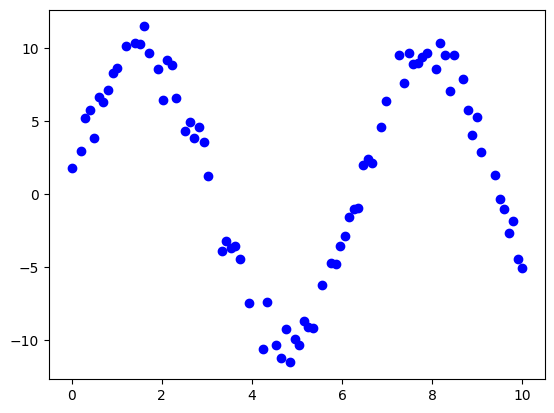

In [94]:
# Generate data
X = np.linspace(0, 10, 100).reshape(-1, 1)  # Ensure X is 2D
Y = (np.sin(X).flatten() + np.random.normal(0, 0.1, 100)) * 10

# Shuffle data
indices = np.arange(100)
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices].reshape(-1, 1)

# Split data
train_X, test_X = X[:80], X[80:]
train_Y, test_Y = Y[:80], Y[80:]

# Plot the training data
plt.scatter(train_X, train_Y, marker="o", color="b")

In [95]:
# Train
net = TAGI([1, 50, 1])
train_X = net.standardize_data(train_X)
train_Y = net.standardize_data(train_Y)


for i in range(len(net.layers) - 1):
    print(
        net.parameters[i]["mw"].shape,
        net.parameters[i]["Sw"].shape,
        net.parameters[i]["mb"].shape,
        net.parameters[i]["Sb"].shape,
    )
    print(
        net.hidden_states[i]["ma"].shape,
        net.hidden_states[i]["Sa"].shape,
        net.hidden_states[i]["J"].shape,
    )
    print(
        net.covariances[i]["covZw"].shape,
        net.covariances[i]["covZb"].shape,
        net.covariances[i]["covZZ"].shape,
    )
    print("-------------------")

# net.forward(train_X[0])
# net.backward(train_Y[1], 0.01)

epochs = 1
for epoch in range(epochs):
    for x, y in zip(train_X, train_Y):
        net.forward(x)
        net.backward(y, 0.01)

(50, 1) (50, 1) (50, 1) (50, 1)
(1, 1) (1, 1) (1, 1)
(50, 1) (50, 1) (50, 1)
-------------------
(1, 50) (1, 50) (1, 1) (1, 1)
(50, 1) (50, 1) (50, 1)
(1, 50) (1, 1) (1, 50)
-------------------
(1,) (1,) (50, 1) (50, 1)
(50, 1) (50, 1) (1, 50) (1, 50)
(1,) (1,) (50, 1) (50, 50)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 50)

In [ ]:
# Predict
test_Y_pred = []
for x in test_X:
    prediction = net.forward(x)
    test_Y_pred.append(prediction[0])
    print(prediction)
test_Y_pred = np.array(test_Y_pred).flatten()
test_Y_pred = net.unstandardize_data(test_Y_pred)

print(test_Y)

[-1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009
 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009
 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009
 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009
 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009
 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009
 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009
 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009 -1.45961009
 -1.45961009 -1.45961009]
[-1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364
 -1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364
 -1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364
 -1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364
 -1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364 -1.86225364
 -1.86225364 -1.86225364 

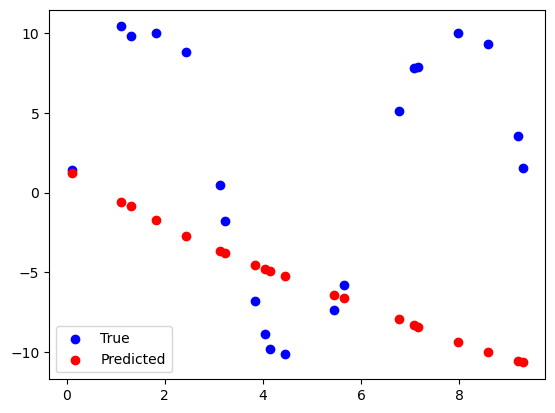

In [ ]:
# Plot
plt.scatter(test_X.flatten(), test_Y, color="blue", label="True")
plt.scatter(test_X.flatten(), test_Y_pred, color="red", label="Predicted")
plt.legend()